In [1]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

results_dir = Path.cwd() / "results"
if not results_dir.exists():
    results_dir = Path.cwd().parent / "results"
if not results_dir.exists():
    raise FileNotFoundError(f"Could not find results directory from {Path.cwd()}")

# MNIST

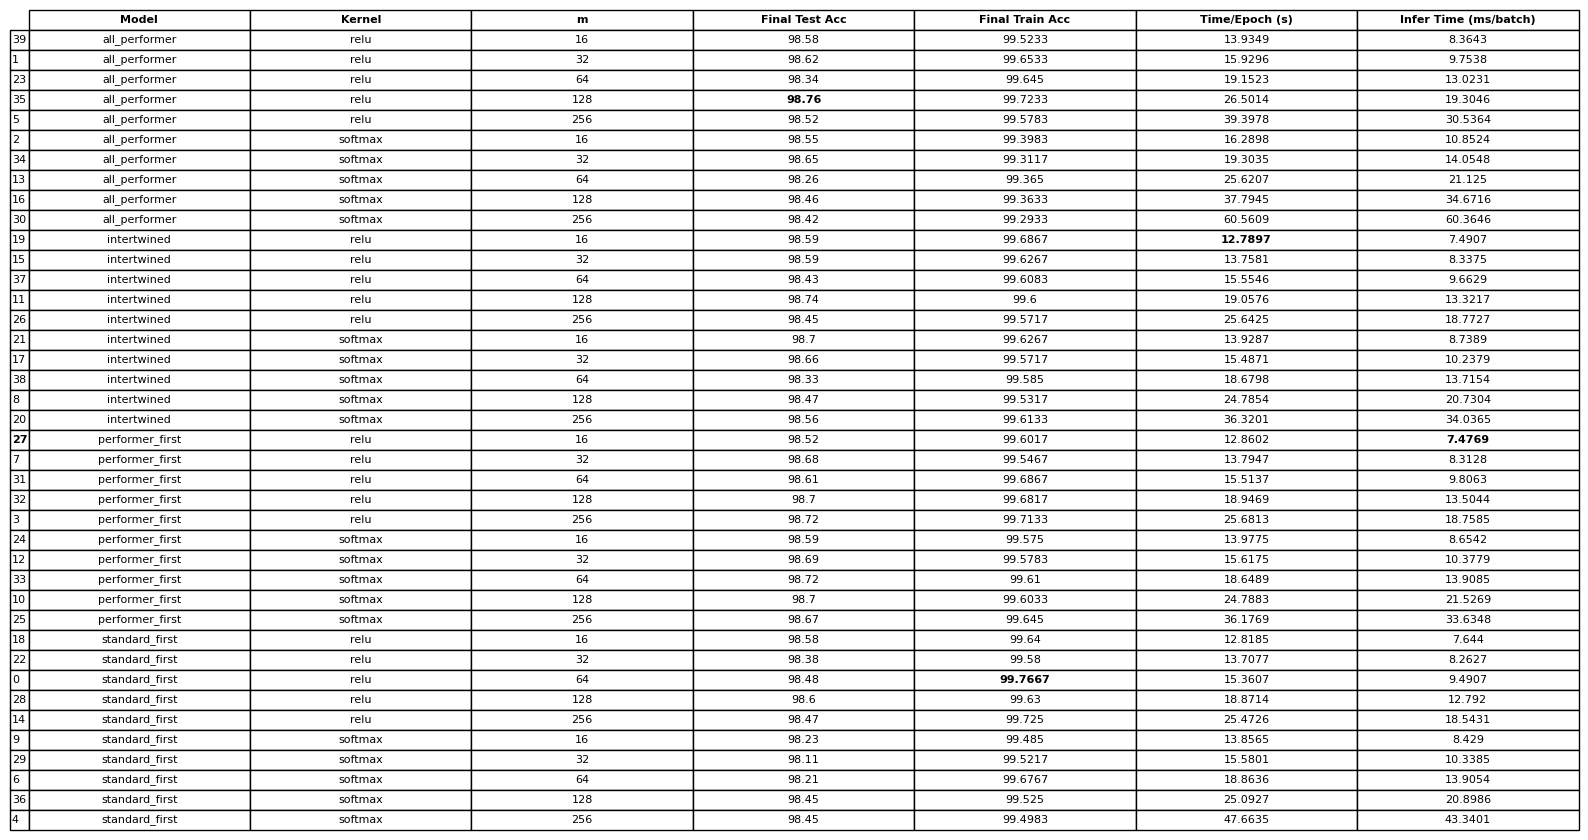

In [3]:
DATASET = "MNIST"

rows = []
for summary_path in results_dir.glob("*/*summary*.csv"):
    ds_name = summary_path.parent.name
    if DATASET and ds_name != DATASET:
        continue

    row = pd.read_csv(summary_path).iloc[0]

    # Derive matching history file (summary_baseline -> history_baseline, etc.)
    history_path = summary_path.with_name(summary_path.name.replace("summary_", "history_"))
    final = {}
    if history_path.exists():
        hist_df = pd.read_csv(history_path)
        if not hist_df.empty:
            final = hist_df.iloc[-1].to_dict()

    rows.append(
        {
            "Model": row.get("architecture"),
            "Kernel": row.get("kernel_type"),
            "m": row.get("m_features"),
            "Final Test Acc": final.get("test_acc", row.get("best_test_acc")),
            "Final Train Acc": final.get("train_acc"),
            "Time/Epoch (s)": final.get("epoch_time", row.get("avg_train_time_per_epoch")),
            "Infer Time (ms/batch)": row.get("infer_time_per_batch_mean_ms"),
        }
    )

if not rows:
    raise ValueError(f"No summary rows found for DATASET={DATASET} in {results_dir}")

table_df = pd.DataFrame(rows)
num_cols = ["Final Test Acc", "Final Train Acc", "Time/Epoch (s)", "Infer Time (ms/batch)"]
for col in num_cols:
    table_df[col] = pd.to_numeric(table_df[col], errors="coerce").round(4)

table_df = table_df.sort_values(["Model", "Kernel", "m"])

best_values = {
    "Final Test Acc": table_df["Final Test Acc"].max(),
    "Final Train Acc": table_df["Final Train Acc"].max(),
    "Time/Epoch (s)": table_df["Time/Epoch (s)"].min(),
    "Infer Time (ms/batch)": table_df["Infer Time (ms/batch)"].min(),
}

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis("off")
tbl = pd.plotting.table(ax, table_df, loc="center", cellLoc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.2)

for (r, c), cell in tbl.get_celld().items():
    if r == 0:  # header
        cell.set_text_props(weight="bold")
        continue
    col_name = table_df.columns[c]
    if col_name in best_values:
        val = table_df.iloc[r - 1, c]
        if pd.notna(val) and val == best_values[col_name]:
            cell.set_text_props(weight="bold")

plt.show()


In [6]:
from pathlib import Path
import pandas as pd

DATASET = "CIFAR10"  # "CIFAR10", "MNIST", or None for both

results_dir = Path.cwd() / "results"
if not results_dir.exists():
    results_dir = Path.cwd().parent / "results"
if not results_dir.exists():
    raise FileNotFoundError(f"Could not find results directory from {Path.cwd()}")

rows = []
for summary_path in results_dir.glob("*/*summary*.csv"):
    ds_name = summary_path.parent.name
    if DATASET and ds_name != DATASET:
        continue

    summary_row = pd.read_csv(summary_path).iloc[0]

    history_path = summary_path.with_name(summary_path.name.replace("summary_", "history_"))
    final = {}
    if history_path.exists():
        hist_df = pd.read_csv(history_path)
        if not hist_df.empty:
            final = hist_df.iloc[-1].to_dict()

    rows.append(
        {
            "Model": summary_row.get("architecture"),
            "Kernel": summary_row.get("kernel_type"),
            "m": int(summary_row["m_features"]) if "m_features" in summary_row else None,
            "Final Test Acc": final.get("test_acc", summary_row.get("best_test_acc")),
            "Final Train Acc": final.get("train_acc"),
            "Time/Epoch (s)": final.get("epoch_time", summary_row.get("avg_train_time_per_epoch")),
            "Infer Time (ms/batch)": summary_row.get("infer_time_per_batch_mean_ms"),
        }
    )

if not rows:
    raise ValueError(f"No summary rows found for DATASET={DATASET} in {results_dir}")

table_df = pd.DataFrame(rows)
num_cols = ["Final Test Acc", "Final Train Acc", "Time/Epoch (s)", "Infer Time (ms/batch)"]
for col in num_cols:
    table_df[col] = pd.to_numeric(table_df[col], errors="coerce").round(4)

table_df = table_df.sort_values(["Model", "Kernel", "m"])

best_values = {
    "Final Test Acc": table_df["Final Test Acc"].max(),
    "Final Train Acc": table_df["Final Train Acc"].max(),
    "Time/Epoch (s)": table_df["Time/Epoch (s)"].min(),
    "Infer Time (ms/batch)": table_df["Infer Time (ms/batch)"].min(),
}

def fmt_val(val, col):
    if pd.isna(val):
        return ""
    s = f"{val:.4f}" if col in num_cols else str(val)
    if col in best_values and val == best_values[col]:
        return r"\textbf{" + s + "}"
    return s

latex = table_df.to_latex(
    index=False,
    escape=False,
    formatters={col: (lambda v, c=col: fmt_val(v, c)) for col in table_df.columns},
    column_format="llr" + "r" * len(num_cols),  # tweak alignment as needed
)

print(latex)


\begin{tabular}{llrrrrr}
\toprule
Model & Kernel & m & Final Test Acc & Final Train Acc & Time/Epoch (s) & Infer Time (ms/batch) \\
\midrule
all_performer & relu & 16 & 72.2900 & 89.0120 & 29.7920 & 12.7822 \\
all_performer & relu & 32 & 74.2700 & \textbf{90.7240} & 32.0413 & 15.1117 \\
all_performer & relu & 64 & 72.9300 & 90.5280 & 37.6810 & 20.5412 \\
all_performer & relu & 128 & 72.4900 & 89.6660 & 48.5818 & 37.3386 \\
all_performer & relu & 256 & 72.4000 & 89.3560 & 66.9876 & 51.2998 \\
all_performer & relu & 512 & 73.8100 & 88.9160 & 106.9143 & 98.2485 \\
all_performer & softmax & 16 & 71.7400 & 83.9420 & 33.2875 & 18.3053 \\
all_performer & softmax & 32 & 72.7300 & 81.9920 & 38.5291 & 23.9698 \\
all_performer & softmax & 64 & 73.3700 & 81.6420 & 47.2564 & 34.7289 \\
all_performer & softmax & 128 & 73.0000 & 82.0760 & 65.7007 & 55.0714 \\
all_performer & softmax & 256 & 73.0900 & 81.6220 & 100.7130 & 97.8083 \\
all_performer & softmax & 512 & 73.6200 & 82.3240 & 172.5789 & 187.13

# CIFAR-10

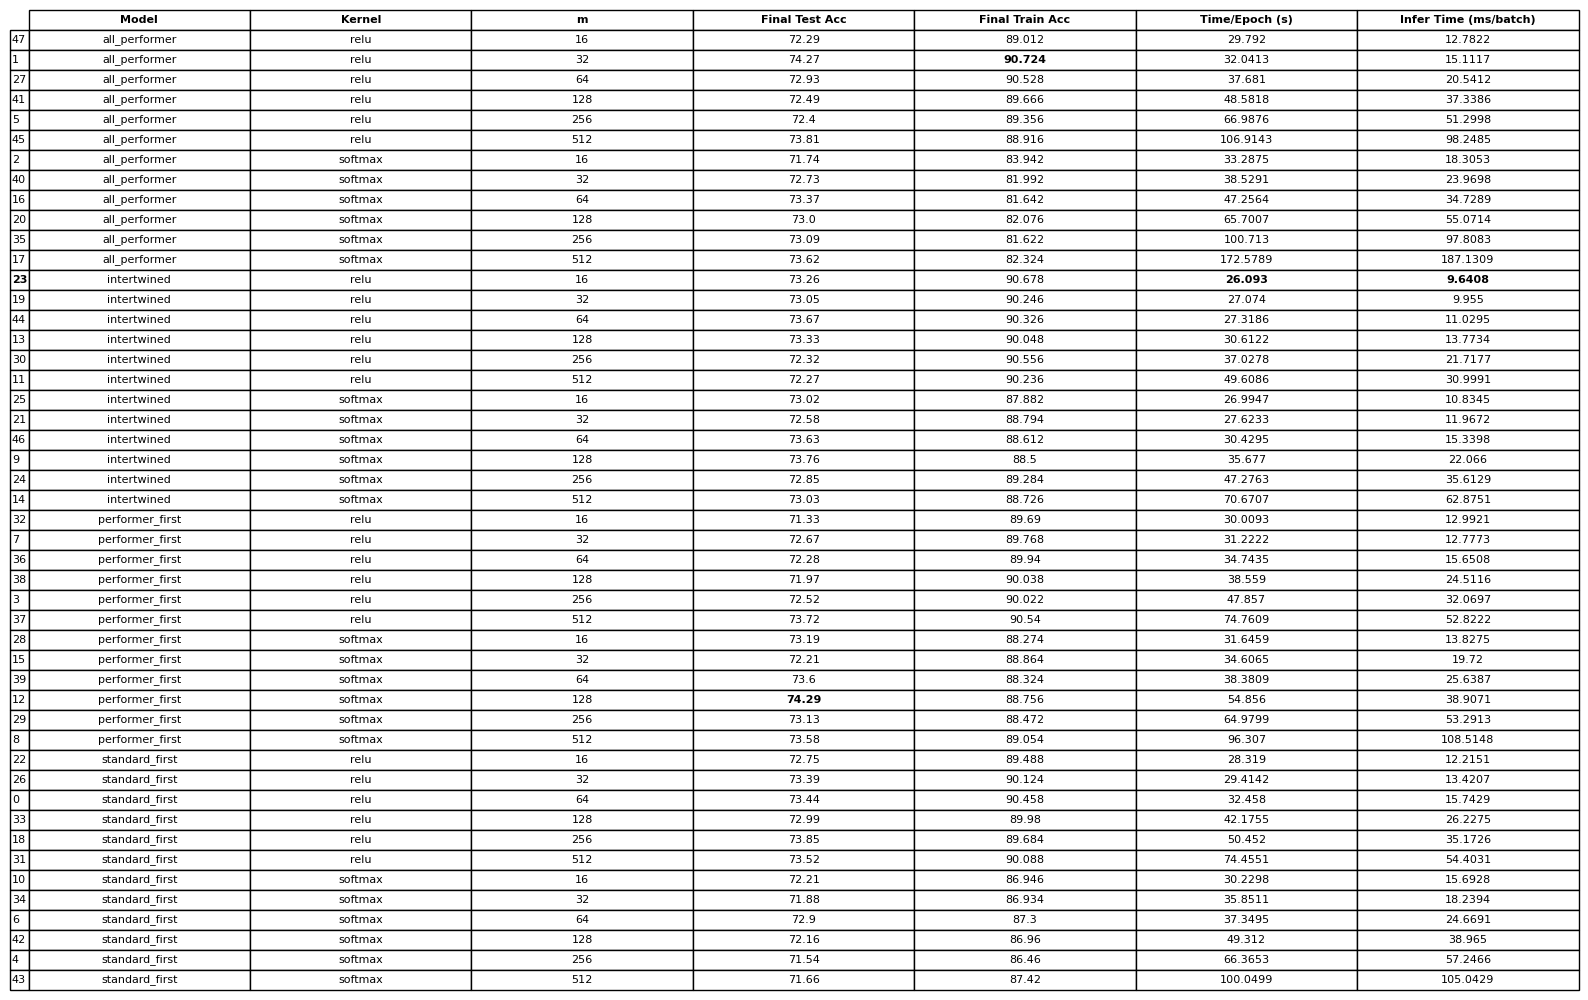

In [8]:
DATASET = "CIFAR10"

rows = []
for summary_path in results_dir.glob("*/*summary*.csv"):
    ds_name = summary_path.parent.name
    if DATASET and ds_name != DATASET:
        continue

    summary_row = pd.read_csv(summary_path).iloc[0]

    history_path = summary_path.with_name(summary_path.name.replace("summary_", "history_"))
    final = {}
    if history_path.exists():
        hist_df = pd.read_csv(history_path)
        if not hist_df.empty:
            final = hist_df.iloc[-1].to_dict()

    rows.append(
        {
            "Model": summary_row.get("architecture"),
            "Kernel": summary_row.get("kernel_type"),
            "m": summary_row.get("m_features"),
            "Final Test Acc": final.get("test_acc", summary_row.get("best_test_acc")),
            "Final Train Acc": final.get("train_acc"),
            "Time/Epoch (s)": final.get("epoch_time", summary_row.get("avg_train_time_per_epoch")),
            "Infer Time (ms/batch)": summary_row.get("infer_time_per_batch_mean_ms"),
        }
    )

if not rows:
    raise ValueError(f"No summary rows found for DATASET={DATASET} in {results_dir}")

table_df = pd.DataFrame(rows)
num_cols = ["Final Test Acc", "Final Train Acc", "Time/Epoch (s)", "Infer Time (ms/batch)"]
for col in num_cols:
    table_df[col] = pd.to_numeric(table_df[col], errors="coerce").round(4)

table_df = table_df.sort_values(["Model", "Kernel", "m"])

best_values = {
    "Final Test Acc": table_df["Final Test Acc"].max(),
    "Final Train Acc": table_df["Final Train Acc"].max(),
    "Time/Epoch (s)": table_df["Time/Epoch (s)"].min(),
    "Infer Time (ms/batch)": table_df["Infer Time (ms/batch)"].min(),
}

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis("off")
tbl = pd.plotting.table(ax, table_df, loc="center", cellLoc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.2)

for (r, c), cell in tbl.get_celld().items():
    if r == 0:
        cell.set_text_props(weight="bold")
        continue
    col_name = table_df.columns[c]
    if col_name in best_values:
        val = table_df.iloc[r - 1, c]
        if pd.notna(val) and val == best_values[col_name]:
            cell.set_text_props(weight="bold")

plt.show()


In [9]:
from pathlib import Path
import pandas as pd

DATASET = "CIFAR10"  # "CIFAR10", "MNIST", or None for both

results_dir = Path.cwd() / "results"
if not results_dir.exists():
    results_dir = Path.cwd().parent / "results"
if not results_dir.exists():
    raise FileNotFoundError(f"Could not find results directory from {Path.cwd()}")

rows = []
for summary_path in results_dir.glob("*/*summary*.csv"):
    ds_name = summary_path.parent.name
    if DATASET and ds_name != DATASET:
        continue

    summary_row = pd.read_csv(summary_path).iloc[0]

    history_path = summary_path.with_name(summary_path.name.replace("summary_", "history_"))
    final = {}
    if history_path.exists():
        hist_df = pd.read_csv(history_path)
        if not hist_df.empty:
            final = hist_df.iloc[-1].to_dict()

    rows.append(
        {
            "Model": summary_row.get("architecture"),
            "Kernel": summary_row.get("kernel_type"),
            "m": int(summary_row["m_features"]) if "m_features" in summary_row else None,
            "Final Test Acc": final.get("test_acc", summary_row.get("best_test_acc")),
            "Final Train Acc": final.get("train_acc"),
            "Time/Epoch (s)": final.get("epoch_time", summary_row.get("avg_train_time_per_epoch")),
            "Infer Time (ms/batch)": summary_row.get("infer_time_per_batch_mean_ms"),
        }
    )

if not rows:
    raise ValueError(f"No summary rows found for DATASET={DATASET} in {results_dir}")

table_df = pd.DataFrame(rows)
num_cols = ["Final Test Acc", "Final Train Acc", "Time/Epoch (s)", "Infer Time (ms/batch)"]
for col in num_cols:
    table_df[col] = pd.to_numeric(table_df[col], errors="coerce").round(4)

table_df = table_df.sort_values(["Model", "Kernel", "m"])

best_values = {
    "Final Test Acc": table_df["Final Test Acc"].max(),
    "Final Train Acc": table_df["Final Train Acc"].max(),
    "Time/Epoch (s)": table_df["Time/Epoch (s)"].min(),
    "Infer Time (ms/batch)": table_df["Infer Time (ms/batch)"].min(),
}

def fmt_val(val, col):
    if pd.isna(val):
        return ""
    s = f"{val:.4f}" if col in num_cols else str(val)
    if col in best_values and val == best_values[col]:
        return r"\textbf{" + s + "}"
    return s

latex = table_df.to_latex(
    index=False,
    escape=False,
    formatters={col: (lambda v, c=col: fmt_val(v, c)) for col in table_df.columns},
    column_format="llr" + "r" * len(num_cols),  # tweak alignment as needed
)

print(latex)


\begin{tabular}{llrrrrr}
\toprule
Model & Kernel & m & Final Test Acc & Final Train Acc & Time/Epoch (s) & Infer Time (ms/batch) \\
\midrule
all_performer & relu & 16 & 72.2900 & 89.0120 & 29.7920 & 12.7822 \\
all_performer & relu & 32 & 74.2700 & \textbf{90.7240} & 32.0413 & 15.1117 \\
all_performer & relu & 64 & 72.9300 & 90.5280 & 37.6810 & 20.5412 \\
all_performer & relu & 128 & 72.4900 & 89.6660 & 48.5818 & 37.3386 \\
all_performer & relu & 256 & 72.4000 & 89.3560 & 66.9876 & 51.2998 \\
all_performer & relu & 512 & 73.8100 & 88.9160 & 106.9143 & 98.2485 \\
all_performer & softmax & 16 & 71.7400 & 83.9420 & 33.2875 & 18.3053 \\
all_performer & softmax & 32 & 72.7300 & 81.9920 & 38.5291 & 23.9698 \\
all_performer & softmax & 64 & 73.3700 & 81.6420 & 47.2564 & 34.7289 \\
all_performer & softmax & 128 & 73.0000 & 82.0760 & 65.7007 & 55.0714 \\
all_performer & softmax & 256 & 73.0900 & 81.6220 & 100.7130 & 97.8083 \\
all_performer & softmax & 512 & 73.6200 & 82.3240 & 172.5789 & 187.13